# Simulação da Hidrólise Enzimática de Biomassa Lignocelulósica
Modelo mecanicista conforme artigo de referência.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# # Parâmetros do modelo
# params = {
#     'alpha': 1,
#     'Emax': 8.32,
#     'Kad': 7.16,
#     'k1r': 0.177,
#     'k2r': 8.81,
#     'k3r': 201.0,
#     'k4r': 16.34,
#     'K1iG2': 0.402,
#     'K1iG': 2.71,
#     'K1iX': 2.15,
#     'K2iG2': 119.6,
#     'K2iG': 4.69,
#     'K2iX': 0.095,
#     'K3M': 26.6,
#     'K3iG': 11.06,
#     'K3iX': 1.023,
#     'K4iG2': 16.25,
#     'K4iG': 4.0,
#     'K4iX': 154.0
# }

# Parâmetros do modelo
params = {
    'alpha': 1,
    'Emax': 7.85,
    'Kad': 6.92,
    'k1r': 0.155,
    'k2r': 7.95,
    'k3r': 180.2,
    'k4r': 15.01,
    'K1iG2': 0.39,
    'K1iG': 2.55,
    'K1iX': 2.02,
    'K2iG2': 110.3,
    'K2iG': 4.51,
    'K2iX': 0.091,
    'K3M': 25.2,
    'K3iG': 10.8,
    'K3iX': 0.98,
    'K4iG2': 15.8,
    'K4iG': 3.85,
    'K4iX': 150.2
}

In [3]:
# Composição da biomassa e condições iniciais
biomass_composition = {
    'cellulose': 0.66,
    'hemicellulose': 0.083,
    'lignin': 0.257
}
solids_loading_g_L = 150  # g/L
C0 = solids_loading_g_L * biomass_composition['cellulose']
H0 = solids_loading_g_L * biomass_composition['hemicellulose']
L0 = solids_loading_g_L * biomass_composition['lignin']
S0 = C0 + H0 + L0
Ef0 = 0.1756  # g/L
Eb0 = 0      # g/L

In [4]:
def Eb(S, Emax, Ef, Kad):
    return S*Emax*Ef/(1+Kad*Ef)

def Ebc(Eb, C, S):
    return Eb * C / S if S > 0 else 0

def Ebh(Eb, H, S):
    return Eb * H / S if S > 0 else 0

def Rs(alpha, S, S0):
    return alpha * S / S0

def r1(k1r, Ebc, S, Rs, G2, G, X, K1iG, K1iG2, K1iX):
    return k1r * Ebc * S * Rs / (1 + G2 / K1iG2 + G / K1iG + X / K1iX)

def r2(k2r, Ebc, S, Rs, G2, G, X, K2iG, K2iG2, K2iX):
    return k2r * Ebc * S * Rs / (1 + G2 / K2iG2 + G / K2iG + X / K2iX)

def r3(k3r, Ef, G2, G, X, K3M, K3iG, K3iX):
    return k3r * Ef * G2 / (((1 + G / K3iG + X / K3iX) * K3M) + G2)

def r4(k4r, Ebh, Rs, S, G2, G, X, K4iG, K4iG2, K4iX):
    return k4r * Ebh * Rs * S / (1 + G2 / K4iG2 + G / K4iG + X / K4iX)

def dC_dt(r1_, r2_):
    return -r1_ - r2_

def dG2_dt(r1_, r3_):
    return 1.056 * r1_ - r3_

def dG_dt(r2_, r3_):
    return 1.111 * r2_ + 1.053 * r3_

def dH_dt(r4_):
    return -r4_

def dX_dt(r4_):
    return 1.136 * r4_

In [5]:
def hydrolysis_ode(t, y, params, S0=S0):
    C, G2, G, H, X, Eb, Ef = y
    L = L0  # Lignin is not used in the ODEs
    S = C + H + L
    alpha = params['alpha']
    Emax = params['Emax']
    Kad = params['Kad']
    k1r = params['k1r']
    k2r = params['k2r']
    k3r = params['k3r']
    k4r = params['k4r']
    K1iG = params['K1iG']
    K1iG2 = params['K1iG2']
    K1iX = params['K1iX']
    K2iG = params['K2iG']
    K2iG2 = params['K2iG2']
    K2iX = params['K2iX']
    K3M = params['K3M']
    K3iG = params['K3iG']
    K3iX = params['K3iX']
    K4iG = params['K4iG']
    K4iG2 = params['K4iG2']
    K4iX = params['K4iX']
    Rs_ = Rs(alpha, S, S0)
    Ebc_ = Ebc(Eb, C, S)
    Ebh_ = Ebh(Eb, H, S)
    r1_ = r1(k1r, Ebc_, S, Rs_, G2, G, X, K1iG, K1iG2, K1iX)
    r2_ = r2(k2r, Ebc_, S, Rs_, G2, G, X, K2iG, K2iG2, K2iX)
    r3_ = r3(k3r, Ef, G2, G, X, K3M, K3iG, K3iX)
    r4_ = r4(k4r, Ebh_, Rs_, S, G2, G, X, K4iG, K4iG2, K4iX)
    # Dinâmica da enzima adsorvida e livre
    taxa_ads = Kad * Ef * (Emax - Eb)
    taxa_dess = Kad * Eb
    dEb_dt = taxa_ads - taxa_dess
    dEf_dt = -dEb_dt
    return [
        dC_dt(r1_, r2_),
        dG2_dt(r1_, r3_),
        dG_dt(r2_, r3_),
        dH_dt(r4_),
        dX_dt(r4_),
        dEb_dt,
        dEf_dt
    ]

y0 = [C0, 0, 0, H0, 0, Eb0, Ef0]
t_span = (0, 96)
t_eval = np.linspace(t_span[0], t_span[1], 200)
solution = solve_ivp(
    hydrolysis_ode, t_span, y0, args=(params, S0), t_eval=t_eval
)

times = solution.t
C = solution.y[0]
G2 = solution.y[1]
G = solution.y[2]
H = solution.y[3]
X = solution.y[4]
Eb = solution.y[5]
Ef = solution.y[6]
L = L0
S_t = C + H + L

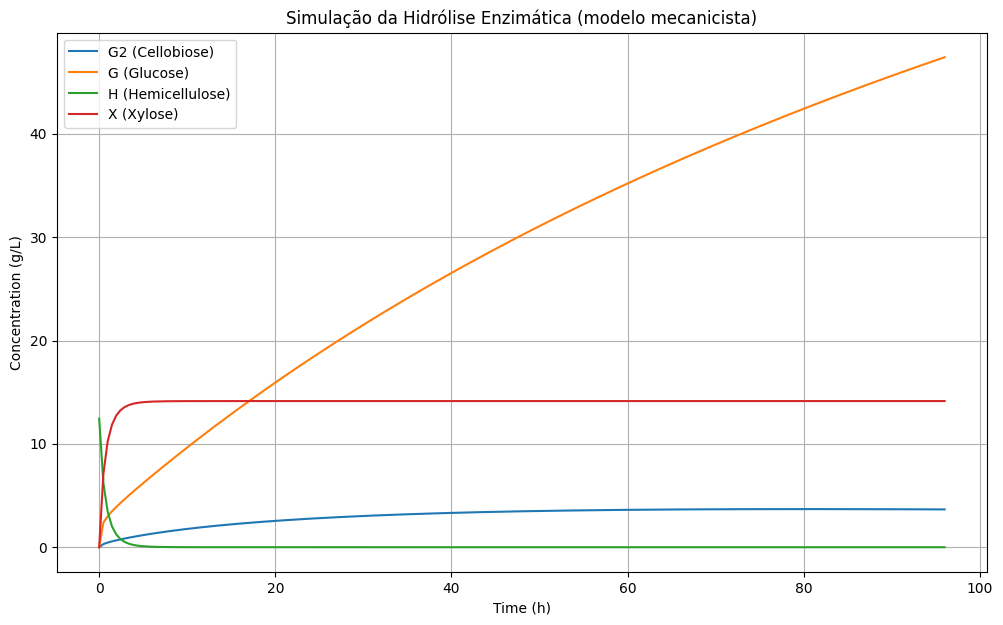

In [6]:
plt.figure(figsize=(12, 7))
# plt.plot(times, C, label="C (Cellulose)")
plt.plot(times, G2, label="G2 (Cellobiose)")
plt.plot(times, G, label="G (Glucose)")
plt.plot(times, H, label="H (Hemicellulose)")
plt.plot(times, X, label="X (Xylose)")
# plt.plot(times, S_t, '--', label="S (Total solids)")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (g/L)")
plt.legend()
plt.title("Simulação da Hidrólise Enzimática (modelo mecanicista)")
plt.grid()
plt.show()

In [7]:
data = {
    'Time (h)': times,
    'Cellulose (C) [g/L]': C,
    'Cellobiose (G2) [g/L]': G2,
    'Glucose (G) [g/L]': G,
    'Hemicellulose (H) [g/L]': H,
    'Xylose (X) [g/L]': X,
    'Total solids (S) [g/L]': S_t,
    'Enzyme free (Ef) [g/L]': Ef
}
df_simulation = pd.DataFrame(data)
df_simulation

,Time (h),Cellulose (C) [g/L],Cellobiose (G2) [g/L],Glucose (G) [g/L],Hemicellulose (H) [g/L],Xylose (X) [g/L],Total solids (S) [g/L],Enzyme free (Ef) [g/L]
0,0.000000,99.000000,0.000000,0.000000,1.245000e+01,0.000000,150.000000,0.175600
1,0.482412,96.561071,0.303031,2.390839,6.181169e+00,7.121392,141.292240,0.020224
2,0.964824,95.875738,0.449354,2.998302,3.441746e+00,10.233376,137.867484,0.020225
3,1.447236,95.343545,0.564655,3.468264,2.031404e+00,11.835525,135.924950,0.020183
4,1.929648,94.872411,0.665605,3.885490,1.246074e+00,12.727659,134.668485,0.020175
...,...,...,...,...,...,...,...,...
195,94.070352,53.365241,3.664443,46.846995,1.116775e-10,14.143200,91.915241,0.020228
196,94.552764,53.238063,3.662818,46.990011,1.061255e-10,14.143200,91.788063,0.020164
197,95.035176,53.111398,3.661151,47.132501,1.008706e-10,14.143200,91.661398,0.020179
198,95.517588,52.985246,3.659440,47.274468,9.589575e-11,14.143200,91.535246,0.020180
